In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import datetime
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import KernelPCA
import numpy as np
import pandas as pd
import math
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
tf.random.set_seed(99)


In [3]:
dataFrame = pd.read_csv('/content/drive/My Drive/data/hanoi_quality.csv', index_col='date')

In [5]:
imputer = SimpleImputer(missing_values=np.nan) # Handling missing values
dataFrame = pd.DataFrame(imputer.fit_transform(dataFrame), columns=dataFrame.columns)
dataFrame = dataFrame.reset_index(drop=True)
# Applying feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(dataFrame.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=list(dataFrame.columns))
target_scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled[['pm25']] = target_scaler.fit_transform(dataFrame[['pm25']].to_numpy())
df_scaled = df_scaled.astype(float)


In [6]:
# Single step dataset preparation
def singleStepSampler(df, window):
	xRes = []
	yRes = []
	for i in range(0, len(df) - window):
		res = []
		for j in range(0, window):
			r = []
			for col in df.columns:
				r.append(df[col][i + j])
			res.append(r)
		xRes.append(res)
		yRes.append(df[['pm25']].iloc[i + window].values)
	return np.array(xRes), np.array(yRes)


In [88]:
# Dataset splitting
SPLIT = 0.7
(xVal, yVal) = singleStepSampler(df_scaled, 20)
X_train = xVal[:int(SPLIT * len(xVal))]
y_train = yVal[:int(SPLIT * len(yVal))]
X_test = xVal[int(SPLIT * len(xVal)):]
y_test = yVal[int(SPLIT * len(yVal)):]

In [89]:
n_forecast = 30

In [90]:
model_gru = keras.Sequential()
model_gru.add(keras.layers.GRU(30, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(keras.layers.Dropout(0.2))
model_gru.add(keras.layers.Dense(n_forecast, activation='linear'))
model_gru.compile(loss = 'MeanSquaredError', metrics=['MAE'], optimizer='Adam')
model_gru.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 30)                3420      
                                                                 
 dropout_4 (Dropout)         (None, 30)                0         
                                                                 
 dense_3 (Dense)             (None, 30)                930       
                                                                 
Total params: 4350 (16.99 KB)
Trainable params: 4350 (16.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [91]:
history = model_gru.fit(X_train, y_train, epochs=20)

Epoch 1/20
42/42 [==============================] - 4s 11ms/step - loss: 0.0488 - MAE: 0.1591
Epoch 2/20
42/42 [==============================] - 1s 12ms/step - loss: 0.0239 - MAE: 0.1158
Epoch 3/20
42/42 [==============================] - 1s 17ms/step - loss: 0.0184 - MAE: 0.1005
Epoch 4/20
42/42 [==============================] - 1s 15ms/step - loss: 0.0155 - MAE: 0.0896
Epoch 5/20
42/42 [==============================] - 1s 16ms/step - loss: 0.0134 - MAE: 0.0825
Epoch 6/20
42/42 [==============================] - 1s 15ms/step - loss: 0.0129 - MAE: 0.0788
Epoch 7/20
42/42 [==============================] - 1s 16ms/step - loss: 0.0117 - MAE: 0.0740
Epoch 8/20
42/42 [==============================] - 1s 17ms/step - loss: 0.0115 - MAE: 0.0718
Epoch 9/20
42/42 [==============================] - 1s 16ms/step - loss: 0.0108 - MAE: 0.0694
Epoch 10/20
42/42 [==============================] - 1s 17ms/step - loss: 0.0106 - MAE: 0.0674
Epoch 11/20
42/42 [==============================] - 1s 13m

In [92]:
# Reload the data with the date index
dataFrame = pd.read_csv('/content/drive/My Drive/data/hanoi_quality.csv') # Assuming the CSV file contains a 'Date' column
dataFrame['date'] = pd.to_datetime(dataFrame['date'])
dataFrame.set_index('date', inplace=True)

# Forecast Plot with Dates on X-axis
predicted_values = model_gru.predict(X_test)

d = {
	'Predicted_pm25': predicted_values[:, 0],
 'Actual_pm25': y_test[:, 0],
}

d = pd.DataFrame(d)
d.index = dataFrame.index[-len(y_test):] # Assigning the correct date index


18/18 [==============================] - 0s 4ms/step


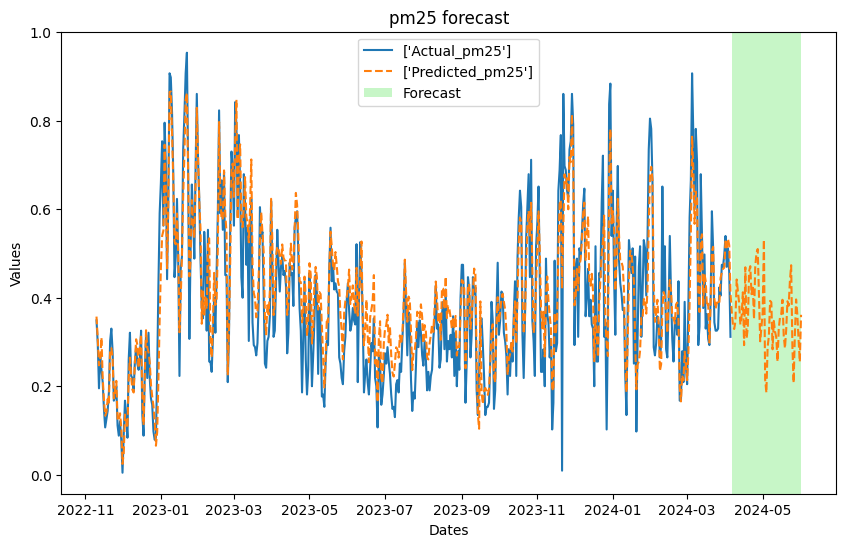

In [93]:
fig, ax = plt.subplots(figsize=(10, 6))
# highlight the forecast
highlight_start = int(len(d) * 0.9)
highlight_end = len(d) - 1 # Adjusted to stay within bounds
# Plot the actual values
plt.plot(d[['Actual_pm25']][:highlight_start], label=['Actual_pm25'])

# Plot predicted values with a dashed line
plt.plot(d[['Predicted_pm25']], label=['Predicted_pm25'], linestyle='--')

# Highlight the forecasted portion with a different color
plt.axvspan(d.index[highlight_start], d.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast')

plt.title('pm25 forecast')
plt.xlabel('Dates')
plt.ylabel('Values')
ax.legend()
plt.show()

In [94]:
predicted_values

array([[0.3573479 , 0.3589461 , 0.3531646 , ..., 0.35107255, 0.36788416,
        0.35962945],
       [0.30671838, 0.30518875, 0.30456564, ..., 0.29869646, 0.31576037,
        0.30430803],
       [0.24722344, 0.24045435, 0.24404529, ..., 0.23830882, 0.25186014,
        0.2401003 ],
       ...,
       [0.30472642, 0.30779463, 0.30609983, ..., 0.28500634, 0.30875456,
        0.2936727 ],
       [0.2555828 , 0.25180534, 0.25424078, ..., 0.23290023, 0.25093418,
        0.24375692],
       [0.36140102, 0.34908804, 0.35734153, ..., 0.3344927 , 0.3472247 ,
        0.3428919 ]], dtype=float32)

In [95]:
predicted_values_90 = predicted_values[:3]

In [96]:
pm25_scaler = target_scaler
# Perform the inverse transformation on the scaled pm25 data
predicted_values_90 = pm25_scaler.inverse_transform(predicted_values_90)

# Check the DataFrame to see the reversed pm25 values
print(predicted_values_90)

[[78.829796 79.173416 77.93039  76.75567  79.13461  78.49324  79.90281
  78.02756  76.17023  75.7979   75.667015 77.36571  77.94136  79.944176
  77.55276  81.44763  77.783585 76.39024  75.748726 77.24532  78.623634
  78.38272  79.4464   79.954765 76.60958  74.15032  78.16976  77.4806
  81.09509  79.32033 ]
 [67.94445  67.61558  67.48161  65.73176  67.99895  68.24782  67.47838
  66.11107  65.7604   65.425606 65.048195 65.75393  66.19     68.231606
  67.39539  70.36547  67.44461  65.42595  65.109795 65.9223   68.11312
  66.83397  68.266846 69.13737  65.79653  63.88255  67.47035  66.219734
  69.88848  67.42622 ]
 [55.153038 53.697685 54.469734 52.261395 54.275513 55.36712  53.943127
  52.510708 53.017933 52.0061   52.030148 52.855217 52.109776 54.695854
  54.065    56.711002 54.438557 51.716366 51.939346 52.40473  55.22393
  53.238937 55.067204 55.61854  52.37551  51.103603 54.9824   53.236397
  56.14993  53.621567]]


In [97]:
predicted_values_90 = np.concatenate(predicted_values_90, axis=0)

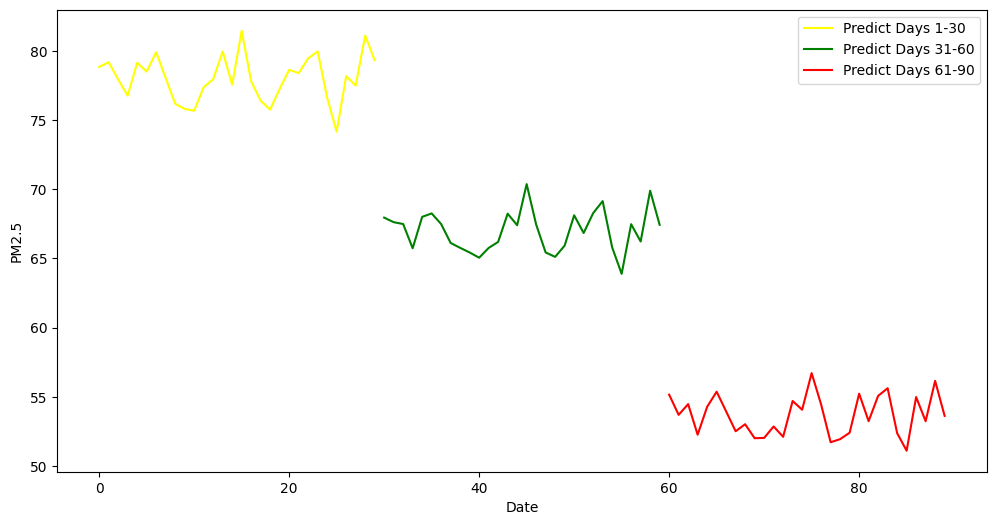

In [98]:
plt.figure(figsize=(12, 6))

dates = np.arange(1, 91)
data = pd.DataFrame({'Date': dates, 'predicted_values_90': predicted_values_90})

plt.plot(data['predicted_values_90'][:30], color='yellow', label='Predict Days 1-30')
plt.plot(data['predicted_values_90'][30:60], color='green', label='Predict Days 31-60')
plt.plot(data['predicted_values_90'][60:], color='red', label='Predict Days 61-90')

# Adding labels and legend
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.legend()

# Show plot
plt.show()

In [102]:
if predicted_values.ndim == 1:
    predicted_values = predicted_values.reshape(-1, 1)

# Inverse transform the predicted values
predicted_values_all = pm25_scaler.inverse_transform(predicted_values)

# Check the shape after inverse transformation
print("Shape of y_test:", y_test.shape)
print("Shape of predicted_values_all:", predicted_values_all.shape)
# Aggregate predictions to match the shape of y_test
predicted_values_aggregated = np.mean(predicted_values_all, axis=1, keepdims=True)

# Calculate the RMSE, MAE, and MAPE
rmse = mean_squared_error(y_test, predicted_values_aggregated, squared=False)
mae = mean_absolute_error(y_test, predicted_values_aggregated)
mape = mean_absolute_percentage_error(y_test, predicted_values_aggregated)

# Print the results
print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mape)


RMSE: 91.74974994818868
MAE: 86.25630540112775
MAPE: 719891856072710.1
